##  Seasonally Adjusted Forecasting in R and Anomaly Detection

In [5]:
# install.packages('forecast', repos = "http://cran.us.r-project.org")
# library(forecast)

In [53]:
wineind # Wine data for Austrailia

       Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov   Dec
1980 15136 16733 20016 17708 18019 19227 22893 23739 21133 22591 26786 29740
1981 15028 17977 20008 21354 19498 22125 25817 28779 20960 22254 27392 29945
1982 16933 17892 20533 23569 22417 22084 26580 27454 24081 23451 28991 31386
1983 16896 20045 23471 21747 25621 23859 25500 30998 24475 23145 29701 34365
1984 17556 22077 25702 22214 26886 23191 27831 35406 23195 25110 30009 36242
1985 18450 21845 26488 22394 28057 25451 24872 33424 24052 28449 33533 37351
1986 19969 21701 26249 24493 24603 26485 30723 34569 26689 26157 32064 38870
1987 21337 19419 23166 28286 24570 24001 33151 24878 26804 28967 33311 40226
1988 20504 23060 23562 27562 23940 24584 34303 25517 23494 29095 32903 34379
1989 16991 21109 23740 25552 21752 20294 29009 25500 24166 26960 31222 38641
1990 14672 17543 25453 32683 22449 22316 27595 25451 25421 25288 32568 35110
1991 16052 22146 21198 19543 22084 23816 29961 26773 26635 26972 30207 38687

### Plot shows increasing variance, we'll choose multiplicative (in place of additive)

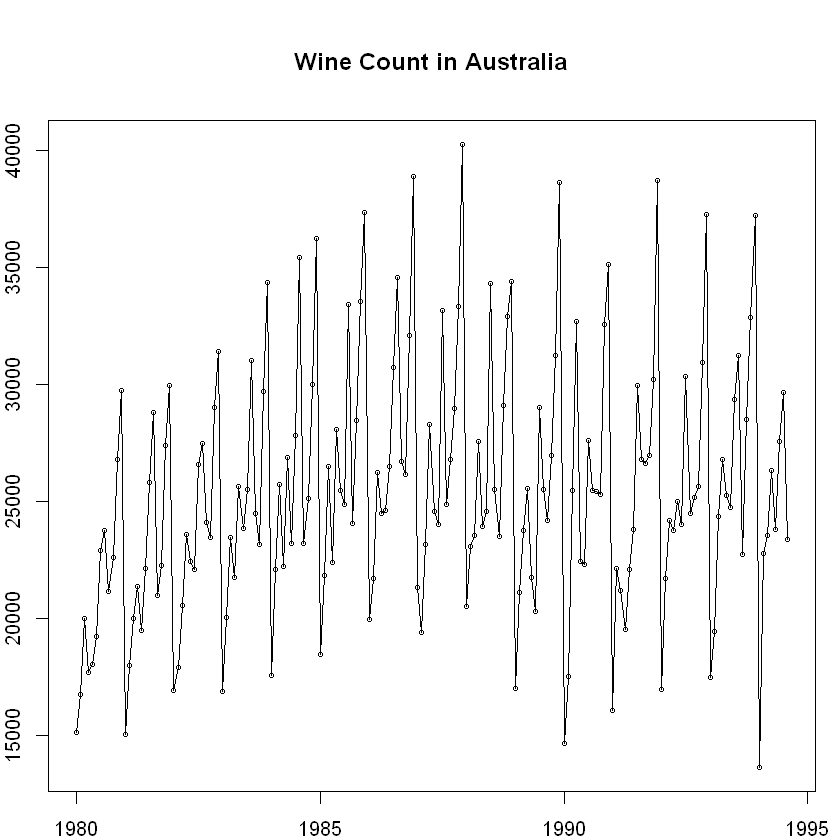

In [47]:
par(mar = c(2,2,5,1))
plot(wineind, main = "Wine Count in Australia")
points(wineind, cex = .5)

### Two ways of plotting data with trends:

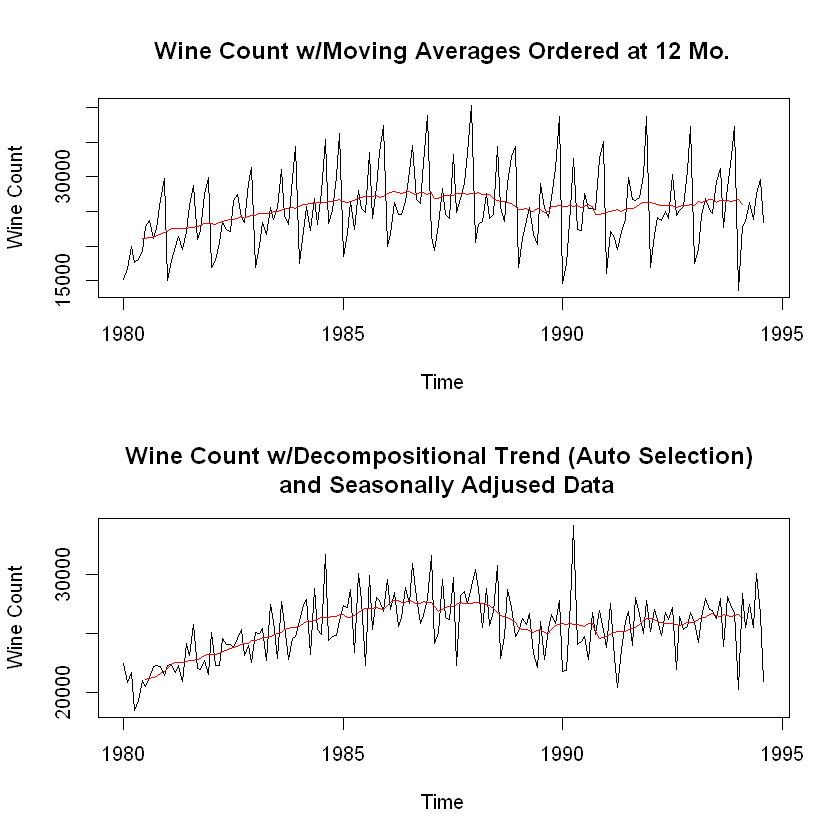

In [52]:
par(mfrow =c(2,1))
maWine <- ma(wineind, order = 12, centre = F) # 12 lagged window
plot(as.ts(wineind), ylab = "Wine Count", main = "Wine Count w/Moving Averages Ordered at 12 Mo.")
lines(maWine, col = 'red')

decompWine <- decompose(wineind, "multiplicative") # Multiplicative used, as stationary is increasing in variance
seasAdjWine <- wineind / decompWine$seasonal
plot(seasAdjWine, ylab = "Wine Count", main = "Wine Count w/Decompositional Trend (Auto Selection) \n and Seasonally Adjused Data")
lines(decompWine$trend, col = "red")

### Plot of each component:

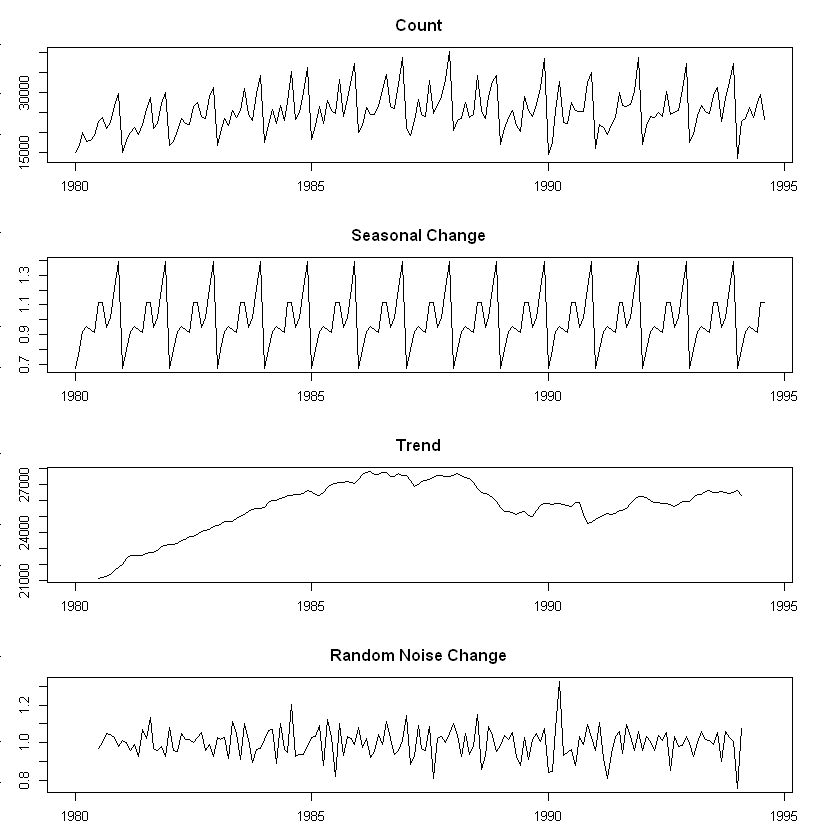

In [10]:
par(mfrow = c(4,1), mar = c(3,3,3,3))
plot(as.ts(decompWine$x), main = "Count")
plot(as.ts(decompWine$seasonal), main = "Seasonal Change")
plot(as.ts(decompWine$trend), main = "Trend")
plot(as.ts(decompWine$random), main = "Random Noise Change")

# plot(decompWine$seasonal * decompWine$trend * decompWine$random) # Same as first

### Two forecasting models using -- accounting for seasonal adjustment:

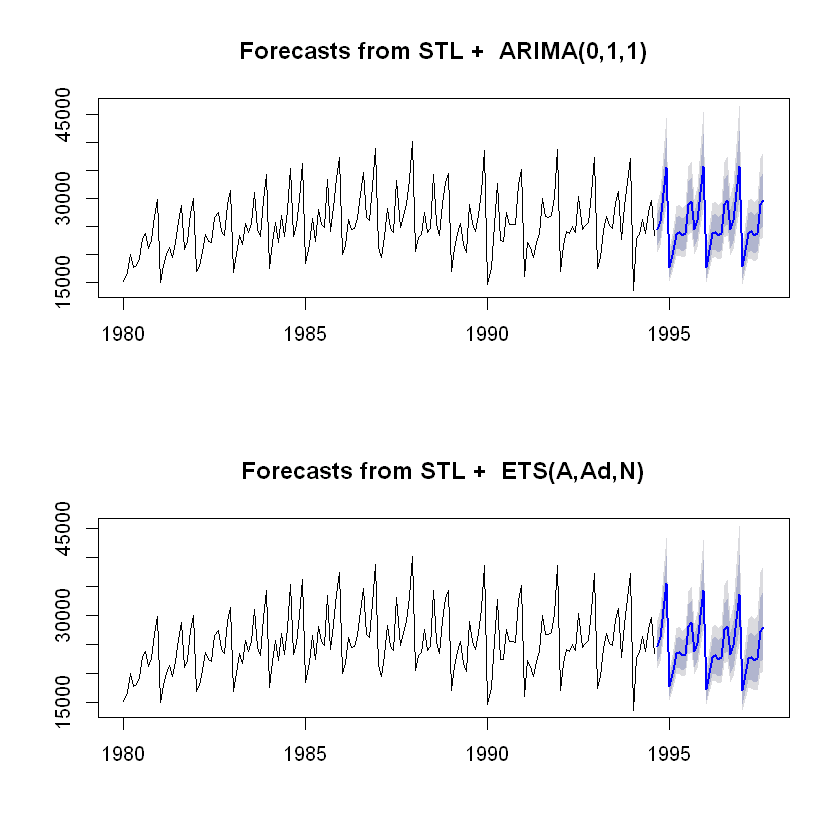

In [48]:
# See help(stlf)
# The inclusion of the Box-Cox parameter as shown here allows non-additive decompositions( multiplicitive here )
# `s.window` parameter as "periodic" adjusts for seasonality.
# `h = 36` months leading
# `method` used for forecasting the seasonally adjusted series.
# `s.window`: Either the character string “periodic” or the span (in lags) of the loess window for seasonal extraction.
# `biasadj`: Use adjusted back-transformed mean for Box-Cox transformations. If TRUE, point forecasts and fitted values are mean forecast. 

modelArima <- stlf(decompWine$x, method = "arima", robust = T, s.window = "periodic", biasadj = T, lambda = BoxCox.lambda(decompWine$x), h = 36)
modelEts <- stlf(decompWine$x, method = "ets", robust = T, s.window = "periodic", biasadj = T, lambda = BoxCox.lambda(decompWine$x), h = 36)

par(mfrow = c(2,1))
plot(modelArima)
plot(modelEts)

# Note: Out of sample tests could be performed on both of the below Arima / ETS models prior to using in anomomoly detection, 
# as the ETS model shows a downward bias versus an upward bias from ARIMA.

Next step would be out-of-sample testing, After varying model parameters and performing cross validation, Anomaly Detection could use point prediction intervals (given margins like the above). With a given new wine volume input above/below the respective prediction margin (e.g., 95% point confidence), an "Anomaly" is detected via it's resepctive point prediction interval.

### Summary of Arima model:

In [37]:
head(modelArima) # Displays model
# str(model)

ERROR: Error in vapply(seq_along(mapped), function(i) {: values must be length 1,
 but FUN(X[[2]]) result is length 0


$method
[1] "STL +  ARIMA(0,1,1)"

$model
Series: x 
ARIMA(0,1,1)                    

Coefficients:
          ma1
      -0.8629
s.e.   0.0297

sigma^2 estimated as 6.8e-07:  log likelihood=997.52
AIC=-1991.04   AICc=-1990.97   BIC=-1984.71

$level
[1] 80 95

$mean
          Jan      Feb      Mar      Apr      May      Jun      Jul      Aug
1994                                                                        
1995 17759.95 20734.79 23646.09 23980.14 23398.61 23777.62 28871.48 29524.86
1996 17777.80 20758.82 23677.00 24011.88 23428.89 23808.84 28916.76 29572.12
1997 17795.64 20782.84 23707.91 24043.63 23459.16 23840.06 28962.05 29619.38
          Sep      Oct      Nov      Dec
1994 24392.43 25960.68 30954.46 35608.44
1995 24425.28 25997.70 31006.32 35676.24
1996 24458.13 26034.72 31058.18 35744.05
1997                                    

$lower
           80%      95%
 [1,] 21655.30 20445.00
 [2,] 22938.52 21611.39
 [3,] 27023.26 25326.89
 [4,] 30755.46 28693.37
 [5,] 15969.85 1

In [15]:
help(stlf)

forecast.stl {forecast},R Documentation
x,A univariate numeric time series of class ts
object,An object of class stl or stlm. Usually the result of a call to stl or stlm.
method,Method to use for forecasting the seasonally adjusted series.
modelfunction,"An alternative way of specifying the function for modelling the seasonally adjusted series. If modelfunction is not NULL, then method is ignored. Otherwise method is used to specify the time series model to be used."
forecastfunction,"An alternative way of specifying the function for forecasting the seasonally adjusted series. If forecastfunction is not NULL, then method is ignored. Otherwise method is used to specify the forecasting method to be used."
etsmodel,"The ets model specification passed to ets. By default it allows any non-seasonal model. If method!=""ets"", this argument is ignored."
xreg,"Historical regressors to be used in auto.arima() when method==""arima""."
newxreg,Future regressors to be used in forecast.Arima().
h,Number of periods for forecasting.
level,Confidence level for prediction intervals.



Resources:

https://anomaly.io/seasonally-adjustement-in-r/

https://anomaly.io/seasonal-trend-decomposition-in-r/

http://robjhyndman.com/hyndsight/forecast3/